STAT 453: Deep Learning (Spring 2024)    
Instructor: Yiqiao Zhong (yiqiao.zhong@wisc.edu)  

*Credits due to Sebastian Raschka*


Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/   
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

---

Note that Python's Imaging Library (PIL) can be installed via 

    conda install pillow 

**If you have any installation issues, please don't hesitate to ask via Piazza!**

# HW 3: Graduate Student Descent! Training and Tuning a Multilayer Perceptron (40 pts)

**Your task in this homework is to take this existing Multilayer Perceptron implementation and change it to achieve a better performance on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist).**

---
<font color='darkred'>
For the successfull outcome of this homework:
    
- Your Validation and Test set accuracies should be

     - greater than 85% for 10 pts
     - greater than 86% for 20 pts
     - greater than 87% for 30 pts
     - greater than 88% for 40 pts    
    

- Answer the questions at the bottom of this notebook
- Submit this Jupyter Notebook with your modifications as .ipynb and .html file to Canvas (similar to previous homeworks)
</font>
---

**And as promised in class, the student with the highest performance will receive a little gift!**

---

Please read and execute this notebook first to make sure everything works correctly. Then, feel free to make any changes to the architecture, i.e., you can change

- the number of layers
- the activation function(s) (logistic sigmoid, tanh, relu, leaky relu, ...)
- the learning rate
- the number of hidden layers
- the number of units in the hidden layer(s)
- the number of epochs
- the minibatch size

However,

- don't change the weight initialization
- don't change the random seed
- don't change the optimization algorithm

The cells where you can/should make changes are clearly highlighted. For instance, I added comments as shown below:

```

```

In [97]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading the Dataset

The dataset consists of 10 classes similar to the original MNIST dataset. Also, it shares the same overall structure with MNIST, i.e., there are 60k training images and 10k test images, and all images are black & white images of size 28x28. 

Below is an example of how the images look like:

![](figures/fashion-mnist-sprite.png)

(Image Source: https://github.com/zalandoresearch/fashion-mnist)



The 10 classes in this dataset are


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Before you continue, please execute the companion notebook "Notebook for Preparing the Dataset for HW3" ([`hw3-dataprep.ipynb`](hw3-dataprep.ipynb)) for downloading and preparing the dataset.

---

## Dataset Loader

In [99]:
from hw3_FashionMNISTDataset import FashionMNISTDataset
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os

In [100]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [101]:
####################################################################
# THIS CELL CAN BE MODIFIED BUT THERE SHOULD NOT BE ANY RANDOMNESS
####################################################################

custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [102]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

BATCH_SIZE = 100

In [103]:
train_dataset = FashionMNISTDataset(csv_path='train.csv',
                                    img_dir='png-files/',
                                    transform=custom_train_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=4)


valid_dataset = FashionMNISTDataset(csv_path='valid.csv',
                                    img_dir='png-files/',
                                    transform=custom_test_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)


test_dataset = FashionMNISTDataset(csv_path='test.csv',
                                   img_dir='png-files/',
                                   transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

The cell below just checks if the dataset can be loaded correctly.

In [104]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 100
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 100
break minibatch for-loop


If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [105]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes

         ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.relu_1 = torch.nn.ReLU()

        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.relu_2 = torch.nn.ReLU()
        
        # Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
    def forward(self, x):
        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED ANYTHNG IN THE __init__ METHOD ABOVE   
        out = self.linear_1(x)
        out = self.relu_1(out)
        
        # Forward pass through the second layer
        out = self.linear_2(out)
        #out = torch.sigmoid(out)
        out = self.relu_2(out)
        
        # Output layer
        logits = self.linear_out(out)
        probas = torch.sigmoid(logits)
        return logits, probas
    
#################################
### Model Initialization
#################################

# the random seed makes sure that the random weight initialization in the model is always the same. In practice, some 
# weights don't work well, and we may also want to try different random seeds. In this homework, this is not necessary.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you added a 
### second hidden layer, you may want to add a hidden_2 parameter here. Also you may want to play with the number of hidden units.
model = MLP(num_features=28*28,
            num_hidden_1=600,
            num_hidden_2=150,
            num_classes=10)

model = model.to(DEVICE)

In [106]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

### For this homework, do not change the optimizer. However, you
### likely want to experiment with the learning rate!
optimizer = torch.optim.SGD(model.parameters(), lr=0.25)
############################################################

In [107]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

NUM_EPOCHS = 11 # Please feel free to change, early stopping?
############################################################

In [108]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/011 | Batch 000/550 | Cost: 2.2892
Epoch: 001/011 | Batch 020/550 | Cost: 1.2319
Epoch: 001/011 | Batch 040/550 | Cost: 0.9047
Epoch: 001/011 | Batch 060/550 | Cost: 0.5995
Epoch: 001/011 | Batch 080/550 | Cost: 0.7087
Epoch: 001/011 | Batch 100/550 | Cost: 0.6998
Epoch: 001/011 | Batch 120/550 | Cost: 0.5509
Epoch: 001/011 | Batch 140/550 | Cost: 0.3619
Epoch: 001/011 | Batch 160/550 | Cost: 0.7008
Epoch: 001/011 | Batch 180/550 | Cost: 0.6520
Epoch: 001/011 | Batch 200/550 | Cost: 0.6135
Epoch: 001/011 | Batch 220/550 | Cost: 0.7364
Epoch: 001/011 | Batch 240/550 | Cost: 0.4045
Epoch: 001/011 | Batch 260/550 | Cost: 0.5745
Epoch: 001/011 | Batch 280/550 | Cost: 0.5595
Epoch: 001/011 | Batch 300/550 | Cost: 0.5559
Epoch: 001/011 | Batch 320/550 | Cost: 0.4193
Epoch: 001/011 | Batch 340/550 | Cost: 0.5346
Epoch: 001/011 | Batch 360/550 | Cost: 0.3530
Epoch: 001/011 | Batch 380/550 | Cost: 0.4527
Epoch: 001/011 | Batch 400/550 | Cost: 0.7551
Epoch: 001/011 | Batch 420/550 | C

# Evaluation (No Need To Change Any Code in This Section!)

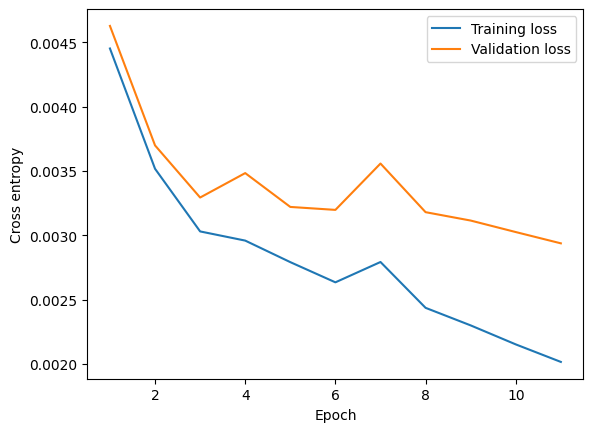

In [109]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

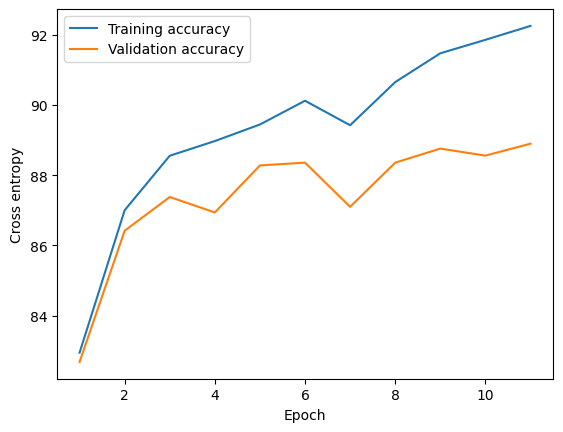

In [110]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [111]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss= compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 88.52%


# Conclusions (YOUR ANSWERS REQUIRED)

**1) What is your training, validation, and test accuracy (paste your numbers from above)? Also, do you notice any overfitting? If yes, why do you think your model is overfitting, and what would be a simple technique to reduce overfitting?**

I don't see any signs of overfitting. The test accuracy is a little bit lower than the train and validation's accuracy, but it is not a substantial difference.

- Training:  92.26%
- Validation: 88.90%
- Test: 88.52%

Changes I made:

- Changed batch size to 100
- Added a second hidden layer 
- Changed to relu activations
- Used 600 and 150 units in the hidden layers
- Increased the learning rate to 0.25
- Changed epochs to 11

**3) Assuming you increased the accuracy by 3%, how many more correct predictions did the improved model make in the test set?**

We know the test set is composed of 10,000 images with labels as given in the hw3-dataprep notebook. So with an 88.52% accuracy, that would be: 
10,000 * 0.8838 = 8,852 correct predictions.